## Convolutional & Conditional VAEs

In this problem you will implement: 
1. a **convolutional** variational autoencoder
2. a (convolutional) **conditional** variational autoencoder,

trained on the MNIST dataset. 
The convolutional parameterization will help you achieve better marginal log likelihood. Using the conditional VAE, you'll be able to generate novel images of a specified class.


In [23]:
%pylab inline
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torch.distributions import MultivariateNormal

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['norm', 'sample', 'show', 'grid']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [24]:
batch_size = 256

train_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=True, download=True, 
          transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True
)




---
# 1. Convolutional variational autoencoder (20 points)


Your task is to implement a VAE for MNIST, using a **convolutional network** in the encoder, and a **convolutional network** in the decoder.

- **Overall Goal:** achieve better estimated marginal likelihood than in the lab
  - Keep `z=20` as in the lab 


**Encoder**: you are free to design the convolutional network how you want. 
  - We used three `Conv2d + ReLU` layers, with an output size of `B x 64 x 7 x 7`.
  - Hint: Flatten the output of your convolutional network before mapping it to the encoder outputs, e.g. $\mu = \texttt{linear(flatten(conv(x)))}$


**Decoder**: you are free to design the convolutional network how you want. 
  - We used three `ConvTranspose2d + ReLU` layers, with an input size of `B x 64 x 7 x 7`.
  - Hint: Map the $\mathbf{z}$ input to the convolutional input size.
    - $\hat{x}=\texttt{deconv(reshape(linear(z)))}$

In [25]:
class Encoder(nn.Module):
  def __init__(self, zdim):
    super().__init__()
    # TODO
    self.zdim = zdim
    self.xdim = 28*28
    self.hdim = 64*7*7
    self.block = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=4, padding=1, stride=2), # 28*28 --> 14*14
        nn.ReLU(),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, padding=1, stride=2), # 14*14 --> 7*7
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # 7*7 --> 7*7
        nn.ReLU()
    )
    self.mu = nn.Linear(self.hdim, self.zdim)
    self.logvar = nn.Linear(self.hdim, self.zdim)
    

  def forward(self, x):
    # TODO
    # pass
    h = self.block(x)
    h = torch.flatten(h, start_dim=1) # B * (64*7*7)
    mu = self.mu(h)
    logvar = self.logvar(h)
    return mu, logvar


class Decoder(nn.Module):
  def __init__(self, zdim):
    super().__init__()
    # pass
    self.zdim = zdim
    self.hdim = 64*7*7
    self.linear = nn.Linear(self.zdim, self.hdim)
    self.block = nn.Sequential(
        nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, padding=1, stride=2, output_padding=1), # 7*7 --> 14*14
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, padding=1, stride=2, output_padding=1), # 14*14 --> 28*28
        nn.ReLU(),
        nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1), # 28*28 --> 28*28
        nn.Sigmoid()
    )


  def forward(self, z):
    # pass
    batch_size = z.size(0)
    x = self.linear(z)
    x = torch.reshape(x, (batch_size, 64, 7, 7))
    out = self.block(x)
    return out



class VAE(nn.Module):
  def __init__(self, zdim):
    super().__init__()
    self.encoder = Encoder(zdim)
    self.decoder = Decoder(zdim)

  def reparameterize(self, mu, logvar):
    if self.training:
      std = torch.exp(0.5*logvar)
      eps = torch.randn_like(std)
      z = mu + std*eps
    else:
      z = mu
    return z

  def forward(self, x):
    mu, logvar = self.encoder(x)
    z = self.reparameterize(mu, logvar)
    xhat = self.decoder(z)
    return xhat, mu, logvar

**Loss**: does anything change from the lab?

we need to flatten the output of decoder 'xhat' to compute BCE.

In [26]:
# hint: see lab
def loss_function(xhat, x, mu, logvar, kl_weight=1.0):
  BCE = nn.functional.binary_cross_entropy(
      xhat.view(xhat.size(0), -1), x.view(x.size(0), -1), reduction='none'
  ).sum(1).mean()
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), 1).mean()

  loss = BCE + kl_weight*KLD
  return loss, BCE.item(), KLD.item()

**Train on MNIST**: does anything change from the lab?

**Your task:** Implement training logic, and *produce a plot of training loss and a plot of validation loss* (x-axis: epoch, y-axis: loss). Each plot should contain three lines: total loss, BCE, and KL-divergence.

In [27]:
device = torch.device("cuda:0")
zdim = 20        # use this
kl_weight = 1.0  # use this

model = VAE(zdim=20).to(device)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
)

In [28]:
from tqdm import tqdm_notebook

def train(epoch):
  # pass
    model.train()
    model.training = True
    train_loss, bce, kld = 0, 0, 0
    for batch_idx, (x, _) in tqdm_notebook(enumerate(train_loader), total=len(train_loader)):
        x = x.to(device)

        optimizer.zero_grad()
        xhat, mu, logvar = model(x)
        loss, bce_, kld_ = loss_function(xhat, x, mu, logvar, kl_weight)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        bce += bce_
        kld += kld_

    train_loss /= len(train_loader)
    bce /= len(train_loader)
    kld /= len(train_loader)
    print('====> Epoch: {} Average loss: {:.4f} (bce {:.4f}, kld {:.4f})'.format(
        epoch, 
        train_loss,
        bce,
        kld
    ))
    return train_loss, bce, kld

def valid(epoch):
  # pass
    cache = dict(mus=[], logvars=[], ys=[])
    mus, logvars, ys = [], [], []
    model.eval()
    model.training = False
    test_loss, bce, kld = 0, 0, 0
    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            x = x.to(device)
            xhat, mu, logvar = model(x)
            loss, bce_, kld_ = loss_function(xhat, x, mu, logvar, kl_weight)

            test_loss += loss.item()
            bce += bce_
            kld += kld_
            cache['mus'].append(mu.detach())
            cache['logvars'].append(logvar.detach())
            cache['ys'].append(y.detach())

    
    test_loss /= len(test_loader)
    bce /= len(test_loader)
    kld /= len(test_loader)
    print('====> Valid set loss: {:.4f} (bce {:.4f}, kld {:.4f})'.format(
        test_loss,
        bce,
        kld
    ))
    return cache, test_loss, bce, kld

In [29]:
# train, validate ..
best_loss = 1e5
cache = dict(mus=[], logvars=[], ys=[], train_loss=[], train_bce=[], train_kld=[], 
             valid_loss=[], valid_bce=[], valid_kld=[])
for epoch in range(1, 20):
  cache_, valid_loss, valid_bce, valid_kld = valid(epoch)
  train_loss, train_bce, train_kld = train(epoch)
  
  for k in cache_:
    cache[k].append(torch.cat(cache_[k]))
  cache['train_loss'].append(train_loss)
  cache['train_bce'].append(train_bce)
  cache['train_kld'].append(train_kld)
  cache['valid_loss'].append(valid_loss)
  cache['valid_bce'].append(valid_bce)
  cache['valid_kld'].append(valid_kld)

  if valid_loss < best_loss:
    torch.save({
        'state_dict': model.state_dict(),
        'cache': cache
    }, open('model.pt', 'wb'))
    best_loss = valid_loss

====> Valid set loss: 545.2363 (bce 545.2259, kld 0.0104)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



====> Epoch: 1 Average loss: 203.2689 (bce 188.5239, kld 14.7450)
====> Valid set loss: 145.2077 (bce 127.2402, kld 17.9675)



====> Epoch: 2 Average loss: 133.2083 (bce 110.9884, kld 22.2199)
====> Valid set loss: 108.4482 (bce 81.2937, kld 27.1545)



====> Epoch: 3 Average loss: 113.6502 (bce 87.4890, kld 26.1611)
====> Valid set loss: 100.8405 (bce 75.0361, kld 25.8044)



====> Epoch: 4 Average loss: 109.6171 (bce 83.3482, kld 26.2689)
====> Valid set loss: 99.3307 (bce 73.1238, kld 26.2068)



====> Epoch: 5 Average loss: 107.6517 (bce 81.4301, kld 26.2216)
====> Valid set loss: 97.8527 (bce 71.0092, kld 26.8435)



====> Epoch: 6 Average loss: 106.3332 (bce 80.1560, kld 26.1772)
====> Valid set loss: 96.2993 (bce 70.5809, kld 25.7184)



====> Epoch: 7 Average loss: 105.4676 (bce 79.2785, kld 26.1892)
====> Valid set loss: 95.8868 (bce 69.2671, kld 26.6197)



====> Epoch: 8 Average loss: 104.6662 (bce 78.5248, kld 26.1414)
====> Valid set loss: 94.9115 (bce 68.7253, kld 26.1862)



====> Epoch: 9 Average loss: 104.0458 (bce 77.9520, kld 26.0938)
====> Valid set loss: 94.6108 (bce 68.7958, kld 25.8150)



====> Epoch: 10 Average loss: 103.5603 (bce 77.5310, kld 26.0293)
====> Valid set loss: 94.4854 (bce 67.9733, kld 26.5120)



====> Epoch: 11 Average loss: 103.0302 (bce 77.0081, kld 26.0221)
====> Valid set loss: 93.1635 (bce 67.6429, kld 25.5206)



====> Epoch: 12 Average loss: 102.6602 (bce 76.6705, kld 25.9897)
====> Valid set loss: 93.1024 (bce 67.5560, kld 25.5465)



====> Epoch: 13 Average loss: 102.2648 (bce 76.3173, kld 25.9475)
====> Valid set loss: 93.9014 (bce 67.0776, kld 26.8238)



====> Epoch: 14 Average loss: 101.9623 (bce 76.0542, kld 25.9080)
====> Valid set loss: 92.5852 (bce 66.6915, kld 25.8937)



====> Epoch: 15 Average loss: 101.6505 (bce 75.8006, kld 25.8499)
====> Valid set loss: 92.8625 (bce 66.7657, kld 26.0968)



====> Epoch: 16 Average loss: 101.4000 (bce 75.5534, kld 25.8466)
====> Valid set loss: 92.2122 (bce 66.6481, kld 25.5641)



====> Epoch: 17 Average loss: 101.0600 (bce 75.3155, kld 25.7445)
====> Valid set loss: 91.8134 (bce 66.6064, kld 25.2070)



====> Epoch: 18 Average loss: 100.8822 (bce 75.1604, kld 25.7218)
====> Valid set loss: 92.1317 (bce 66.8115, kld 25.3202)



====> Epoch: 19 Average loss: 100.6980 (bce 74.9676, kld 25.7304)


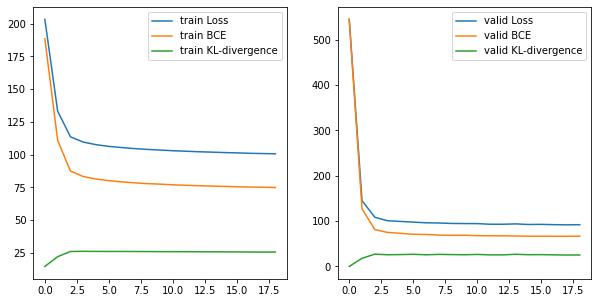

In [31]:
# produce plot ...
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 5))
plt.subplot(1,2,1)
plt.plot(cache['train_loss'], label = 'train Loss')
plt.plot(cache['train_bce'], label = 'train BCE')
plt.plot(cache['train_kld'], label = 'train KL-divergence')
plt.legend()

plt.subplot(1,2,2)
plt.plot(cache['valid_loss'], label = 'valid Loss')
plt.plot(cache['valid_bce'], label = 'valid BCE')
plt.plot(cache['valid_kld'], label = 'valid KL-divergence')
plt.legend()

### Evaluation
- **We provide the code below for sampling, interpolation, and marginal likelihood estimation**
- Sampling and interpolation: achieve similar to the lab (this is subjective, so the purpose is to check if something is *way off*)
- Marginal likelihood: achieve lower than the lab



*Please ensure that `model` contains the model state that you will use for evaluation before running these.*

#### Sampling

*no code modification needed*

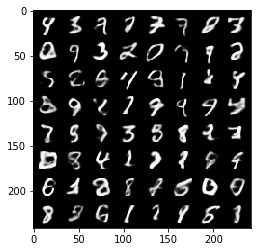

In [32]:
from torchvision.utils import make_grid

N = 64
model.eval()
model.training = False

# Sample z~p(z)
z = torch.randn((N, model.encoder.zdim)).to(device)

# Decode
sample = model.decoder(z)

# Visualize
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

imgs = sample
grid = make_grid(imgs).detach().cpu()
show(grid)

#### Interpolation

*no code modification needed*

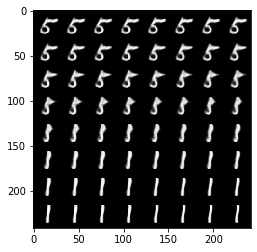

In [39]:
model.eval()
model.training = False

x, y = next(train_loader.__iter__())
xhat, mu, logvar = model(x.cuda())
si, ei = np.random.choice(batch_size, size=2, replace=False)
start = mu[si]
end = mu[ei]

N = 64

zs = torch.zeros(N, model.encoder.zdim).to(device)
for i in range(N):
    zs[i] = i / (N) * start.data + (1 - i / (N) ) * end.data
xhat = model.decoder(zs)

imgs = xhat.unsqueeze(0).unsqueeze(0).view(N, 1, 28, 28)
grid = make_grid(imgs).detach().cpu()
show(grid)

#### Marginal likelihood

*no code modification needed*

In [40]:
torch.manual_seed(42)
torch.cuda.manual_seed_all(42)

eval_loader = torch.utils.data.DataLoader(
    MNIST('./data', train=False, transform=transforms.ToTensor()),
    batch_size=1, shuffle=True)

N_samples = 128

model.eval()
model.training = False

results = []
with torch.no_grad():
  for i, (x, y) in tqdm_notebook(enumerate(eval_loader), total=len(eval_loader)):
    x, y = next(eval_loader.__iter__())
    x = x.to(device).expand(N_samples, 1, 28, 28)

    # Obtain mu, logvar and sample z
    _, mu, logvar = model(x)
    z = mu + logvar.mul(0.5).exp()*torch.randn_like(mu)

    # Obtain xhat given the sampled z
    xhat = model.decoder(z)

    # Make a standard normal for p(z) and a normal for q(z|x)
    norm = MultivariateNormal(
        torch.zeros_like(mu[0]), 
        covariance_matrix=torch.diag(torch.ones_like(logvar[0]))
    )
    mvn = MultivariateNormal(
        mu[0], 
        covariance_matrix=torch.diag(logvar.exp()[0])
    )

    # Measure the (log) probabilities needed for the formula above
    log_pz = norm.log_prob(z)
    log_qzx = mvn.log_prob(z)
    x = x.view(xhat.size())
    log_pxz = -nn.functional.binary_cross_entropy(
        xhat, x, reduction='none'
    ).view(N_samples, -1).sum(1)

    # Compute the lowerbound (in log space)
    argsum = log_pxz + log_pz - log_qzx
    logpx = -np.log(N_samples) + torch.logsumexp(argsum, 0)
    results.append(logpx.item())

np.mean(results)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


-95.77745993003845

We achieved a better marginal likelihood than that of the lab, which is -97.70802133541108



---

# 2. Conditional variational autoencoder (20 points)

### A. Model

The conditional VAE involves:
- $q_{\phi}(\mathbf{z}|\mathbf{x},c)$: "encoder"
- $p_{\theta}(\mathbf{x}|\mathbf{z},c)$: "decoder"
- $p(\mathbf{z})$: prior

In our case, $c\in \{0,...,9\}$ is a discrete variable (class label).

**Your task:** Implement a `CVAE` that has an `encoder`, `decoder`, and `reparameterization`.

*Hints*: 
  1. Represent $c$ using a `nn.Embedding` layer, and concatenate it to the representation of $\mathbf{x}$.
    - e.g. $\mu = \texttt{linear([conv(x); emb(c)])}$
  2. Represent `decoder` inputs $\mathbf{z},c$ similarly, as $[\mathbf{z};\text{emb}(c)]$.
    - $\hat{x}=\texttt{deconv(linear([z; emb(c)]))}$

Otherwise, everything else is the same as VAE (plus passing $c$ as an argument in the right places). You can use the same convolutional layers as above.

In [41]:
class Encoder(nn.Module):
  def __init__(self, zdim, nclasses):
    super().__init__()
    # TODO
    self.zdim = zdim
    self.xdim = 28*28
    self.hdim = 64*7*7
    self.cdim = 16

    self.cls = nn.Embedding(nclasses, self.cdim)

    self.mlp = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=4, padding=1, stride=2), # 28*28 --> 14*14
        nn.ReLU(),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, padding=1, stride=2), # 14*14 --> 7*7
        nn.ReLU(),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1), # 7*7 --> 7*7
        nn.ReLU()
    )
    self.mu = nn.Linear(self.hdim + self.cdim, self.zdim)
    self.logvar = nn.Linear(self.hdim + self.cdim, self.zdim)

  def forward(self, x, c):
    # TODO
    h = self.mlp(x)
    h = torch.flatten(h, start_dim=1) # B * (64*7*7)

    c = self.cls(c)
    h = torch.cat((h, c), dim=1)

    mu = self.mu(h)
    logvar = self.logvar(h)
    return mu, logvar

class Decoder(nn.Module):
  def __init__(self, zdim, nclasses):
    super().__init__()
    # TODO
    self.zdim = zdim
    self.hdim = 64*7*7
    self.cdim = 10
    self.cls = nn.Embedding(nclasses, self.cdim)
    self.linear = nn.Linear(self.zdim + self.cdim, self.hdim)
    self.mlp = nn.Sequential(
        nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, padding=1, stride=2, output_padding=1), # 7*7 --> 14*14
        nn.ReLU(),
        nn.ConvTranspose2d(in_channels=32, out_channels=16, kernel_size=3, padding=1, stride=2, output_padding=1), # 14*14 --> 28*28
        nn.ReLU(),
        nn.Conv2d(in_channels=16, out_channels=1, kernel_size=3, padding=1), # 28*28 --> 28*28
        nn.Sigmoid()
    )
  
  def forward(self, z, c):
    # TODO
    batch_size = z.size(0)
    c = self.cls(c)
    z = torch.cat((z, c), dim=1)
    x = self.linear(z)
    x = torch.reshape(x, (batch_size, 64, 7, 7))
    out = self.mlp(x)
    return out


class CVAE(nn.Module):
  def __init__(self, zdim, nclasses):
    super().__init__()
    # TODO
    self.encoder = Encoder(zdim, nclasses)
    self.decoder = Decoder(zdim, nclasses)

  def reparameterize(self, mu, logvar):
    # TODO
    if self.training:
      std = torch.exp(0.5*logvar)
      eps = torch.randn_like(std)
      z = mu + std*eps
    else:
      z = mu
    return z

  def forward(self, x, c):
    # TODO
    mu, logvar = self.encoder(x, c)
    z = self.reparameterize(mu, logvar)
    xhat = self.decoder(z, c)
    return xhat, mu, logvar

**Loss:** same as VAE.

In [42]:
def loss_function(xhat, x, mu, logvar, kl_weight=1.0):
  BCE = nn.functional.binary_cross_entropy(
      xhat.view(xhat.size(0), -1), x.view(x.size(0), -1), reduction='none'
  ).sum(1).mean()
  KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), 1).mean()

  loss = BCE + kl_weight*KLD
  return loss, BCE.item(), KLD.item()

### C. Training

Train your conditional VAE model using your loss function on MNIST.

**Your task:** Implement training logic, and *produce a plot of training loss and a plot of validation loss* (x-axis: epoch, y-axis: loss). Each plot should contain three lines: total loss, BCE, and KL-divergence.


In [43]:
device = torch.device("cuda:0")
zdim = 20        # use this
kl_weight = 1.0  # use this

model = CVAE(zdim=20, nclasses=10).to(device)
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=1e-3,
)

In [44]:
from tqdm import tqdm_notebook

def train(epoch):
  # pass
    model.train()
    model.training = True
    train_loss, bce, kld = 0, 0, 0
    for batch_idx, (x, c) in tqdm_notebook(enumerate(train_loader), total=len(train_loader)):
        x = x.to(device)
        c = c.to(device)

        optimizer.zero_grad()
        xhat, mu, logvar = model(x, c)
        loss, bce_, kld_ = loss_function(xhat, x, mu, logvar, kl_weight)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        bce += bce_
        kld += kld_

    train_loss /= len(train_loader)
    bce /= len(train_loader)
    kld /= len(train_loader)
    print('====> Epoch: {} Average loss: {:.4f} (bce {:.4f}, kld {:.4f})'.format(
        epoch, 
        train_loss,
        bce,
        kld
    ))
    return train_loss, bce, kld

def valid(epoch):
  # pass
    cache = dict(mus=[], logvars=[], ys=[])
    mus, logvars, ys = [], [], []
    model.eval()
    model.training = False
    test_loss, bce, kld = 0, 0, 0
    with torch.no_grad():
        for i, (x, y) in enumerate(test_loader):
            x = x.to(device)
            y = y.to(device)
            xhat, mu, logvar = model(x, y)
            loss, bce_, kld_ = loss_function(xhat, x, mu, logvar, kl_weight)

            test_loss += loss.item()
            bce += bce_
            kld += kld_
            cache['mus'].append(mu.detach())
            cache['logvars'].append(logvar.detach())
            cache['ys'].append(y.detach())

    test_loss /= len(test_loader)
    bce /= len(test_loader)
    kld /= len(test_loader)
    print('====> Valid set loss: {:.4f} (bce {:.4f}, kld {:.4f})'.format(
        test_loss,
        bce,
        kld
    ))
    return cache, test_loss, bce, kld

In [45]:
# train, validate ..
best_loss = 1e5
cache = dict(mus=[], logvars=[], ys=[], train_loss=[], train_bce=[], train_kld=[], 
             valid_loss=[], valid_bce=[], valid_kld=[])
for epoch in range(1, 20):
  cache_, valid_loss, valid_bce, valid_kld = valid(epoch)
  train_loss, train_bce, train_kld = train(epoch)
  
  for k in cache_:
    cache[k].append(torch.cat(cache_[k]))
  cache['train_loss'].append(train_loss)
  cache['train_bce'].append(train_bce)
  cache['train_kld'].append(train_kld)
  cache['valid_loss'].append(valid_loss)
  cache['valid_bce'].append(valid_bce)
  cache['valid_kld'].append(valid_kld)

  if valid_loss < best_loss:
    torch.save({
        'state_dict': model.state_dict(),
        'cache': cache
    }, open('model.pt', 'wb'))
    best_loss = valid_loss

====> Valid set loss: 563.1428 (bce 563.1095, kld 0.0333)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



====> Epoch: 1 Average loss: 200.8120 (bce 189.3591, kld 11.4529)
====> Valid set loss: 141.5782 (bce 127.8744, kld 13.7038)



====> Epoch: 2 Average loss: 128.1829 (bce 109.4204, kld 18.7624)
====> Valid set loss: 102.6575 (bce 80.3319, kld 22.3256)



====> Epoch: 3 Average loss: 109.0725 (bce 86.4012, kld 22.6713)
====> Valid set loss: 97.5394 (bce 74.3287, kld 23.2107)



====> Epoch: 4 Average loss: 105.2141 (bce 82.6068, kld 22.6072)
====> Valid set loss: 95.5882 (bce 72.8962, kld 22.6920)



====> Epoch: 5 Average loss: 103.2094 (bce 80.7191, kld 22.4903)
====> Valid set loss: 93.3288 (bce 71.3973, kld 21.9315)



====> Epoch: 6 Average loss: 101.8282 (bce 79.4152, kld 22.4129)
====> Valid set loss: 92.5667 (bce 69.9544, kld 22.6124)



====> Epoch: 7 Average loss: 100.8510 (bce 78.5402, kld 22.3107)
====> Valid set loss: 91.5433 (bce 69.7231, kld 21.8203)



====> Epoch: 8 Average loss: 100.0347 (bce 77.8281, kld 22.2067)
====> Valid set loss: 91.1948 (bce 68.6264, kld 22.5684)



====> Epoch: 9 Average loss: 99.3565 (bce 77.2521, kld 22.1044)
====> Valid set loss: 90.1058 (bce 68.3504, kld 21.7554)



====> Epoch: 10 Average loss: 98.8074 (bce 76.8038, kld 22.0035)
====> Valid set loss: 89.8138 (bce 67.6209, kld 22.1929)



====> Epoch: 11 Average loss: 98.2923 (bce 76.3590, kld 21.9333)
====> Valid set loss: 90.1828 (bce 68.9632, kld 21.2196)



====> Epoch: 12 Average loss: 97.8624 (bce 76.0476, kld 21.8149)
====> Valid set loss: 89.1028 (bce 67.3852, kld 21.7176)



====> Epoch: 13 Average loss: 97.4315 (bce 75.7038, kld 21.7277)
====> Valid set loss: 88.9165 (bce 67.3770, kld 21.5395)



====> Epoch: 14 Average loss: 97.0973 (bce 75.4363, kld 21.6610)
====> Valid set loss: 89.3298 (bce 67.1851, kld 22.1447)



====> Epoch: 15 Average loss: 96.7539 (bce 75.1853, kld 21.5686)
====> Valid set loss: 88.0209 (bce 66.4268, kld 21.5941)



====> Epoch: 16 Average loss: 96.4224 (bce 74.9202, kld 21.5021)
====> Valid set loss: 87.5548 (bce 67.0345, kld 20.5203)



====> Epoch: 17 Average loss: 96.1416 (bce 74.7149, kld 21.4267)
====> Valid set loss: 87.4568 (bce 66.5664, kld 20.8904)



====> Epoch: 18 Average loss: 95.8527 (bce 74.4880, kld 21.3647)
====> Valid set loss: 86.9066 (bce 66.1641, kld 20.7425)



====> Epoch: 19 Average loss: 95.5746 (bce 74.3018, kld 21.2729)


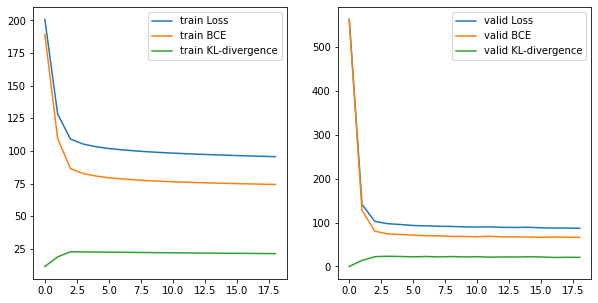

In [46]:
# produce plot ...
import matplotlib.pyplot as plt
plt.figure(figsize = (10, 5))
plt.subplot(1,2,1)
plt.plot(cache['train_loss'], label = 'train Loss')
plt.plot(cache['train_bce'], label = 'train BCE')
plt.plot(cache['train_kld'], label = 'train KL-divergence')
plt.legend()

plt.subplot(1,2,2)
plt.plot(cache['valid_loss'], label = 'valid Loss')
plt.plot(cache['valid_bce'], label = 'valid BCE')
plt.plot(cache['valid_kld'], label = 'valid KL-divergence')
plt.legend()

### D. Conditional generation

**Your task**: complete the code below to produce a grid of samples with 10 rows, where the $i$'th row has samples of class $i$.

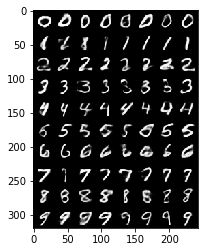

In [47]:
from torchvision.utils import make_grid
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')


N = 8
model.eval()
model.training = False
grids = []
sample = torch.tensor([]).to(device)

for y_ in range(10):
  # TODO (the ... does not imply it is a single line)
  # sample = ...
  y = torch.tensor([y_]*N).to(device)
  z = torch.randn((N, model.encoder.zdim)).to(device)
  sample = model.decoder(z, y)

  grid = make_grid(sample).detach().cpu()
  grids.append(grid)

grid = torch.cat(grids, 1)
show(grid);